In [260]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
import seaborn as sns
import pandas as pd
from environment.TheoreticalMarket import *

In [261]:
filename = "sim_results/market-marl-nash-3-05-07-2022-00-17-5840_results.pkl"
# .pkl based on an older version, in the new version "res.avg_epoch_rewards" and is renamed to "res.avg_episode_rewards"

with open(filename, 'rb') as f:
    res = pkl.load(f)

sns.set_theme(style="darkgrid")
data_losses = {"Q Function Loss": res.losses, "Epsilon Function Loss": res.losses_eps, "Nash Net Loss": res.losses_nash}
data_losses_df = pd.DataFrame(data=data_losses)

In [262]:
res.marl_params

{'epochs': 40,
 'explore_epsilon': 0.05,
 'max_steps': 30,
 'sync_freq': 20,
 'mem_size': 101333,
 'turbo_max_evals': 5,
 'turbo_batch_size': 5,
 'turbo_n_init': 5,
 'batch_size': 10}

In [296]:
res.mdp_env.beta0, res.mdp_env.beta1, res.mdp_env.beta2, res.mdp_env.n_agents

(15, -1.05, -3.1, 3)

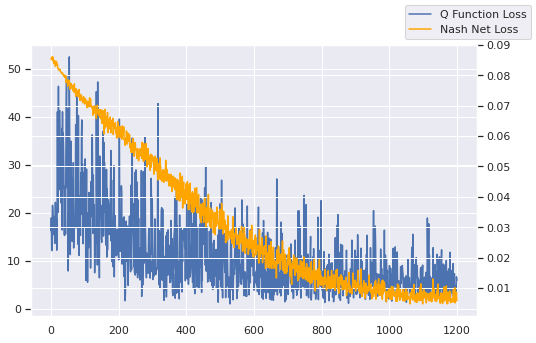

In [264]:
# import matplotlib.pyplot as plt

max_len = 1200
ax = data_losses_df[:max_len].plot(y="Q Function Loss", legend=False, figsize=(8, 5))
ax2 = ax.twinx()

data_losses_df[:max_len].plot(y="Nash Net Loss", ax=ax2, legend=False, color="orange")

ax.figure.legend()


In [265]:
from scipy.ndimage.interpolation import shift
import copy

# Market parameters

a = 0.1

beta0 = res.mdp_env.beta0
beta1 = res.mdp_env.beta1
beta2 = res.mdp_env.beta2

ref_prices = res.state_tracker[:,-1]
episode_rewards = res.episode_rewards[:,-1]

joint_actions = res.episode_actions
episode_joint_actions = joint_actions[:,-1]

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

nash_eps_bounds = [get_eps0_range(ref_price, Y, X, z) for ref_price in ref_prices ]
nash_lower_bound =  [v[0] for v in nash_eps_bounds]
nash_upper_bound =  [v[1] for v in nash_eps_bounds]

computed_ref_price = np.mean(res.episode_actions[:,-1, :], axis =1)
computed_avg_action = shift(computed_ref_price, -1, cval=computed_ref_price[-1])
computed_ref_price_pair = np.array([computed_ref_price, computed_avg_action]).T

nash_eps_bounds_all_ep = [get_eps0_range(ref_price, Y, X, z) for ref_price in computed_ref_price]
nash_lower_bound_all_ep =  [v[0] for v in nash_eps_bounds_all_ep]
nash_upper_bound_all_ep =  [v[1] for v in nash_eps_bounds_all_ep]

ref_prices = res.state_tracker[:,-1]

episode_rewards = res.episode_rewards[:,-1]

joint_actions = res.episode_actions
episode_joint_actions = joint_actions[:,-1]

prices = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[0] for r in ref_prices])
devs = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[1] for r in ref_prices])
demand = np.array([get_nash_eps_curve(r, beta0, beta1, beta2, a)[2] for r in ref_prices])

y = ref_prices
x = prices[0]
X, Y = np.meshgrid(x, y) 
z = devs

nash_lower_bound_ref_pair = copy.deepcopy(computed_ref_price_pair)
nash_upper_bound_ref_pair = copy.deepcopy(computed_ref_price_pair)
nash_lower_bound_ref_pair[:, 1] = nash_lower_bound_all_ep
nash_upper_bound_ref_pair[:, 1] = nash_upper_bound_all_ep
nash_lower_bound_all_rev_ep =  [est_revenue_from_refprice(v, beta0, beta1, beta2) for v in nash_lower_bound_ref_pair]
nash_upper_bound_all_rev_ep =  [est_revenue_from_refprice(v, beta0, beta1, beta2) for v in nash_upper_bound_ref_pair]

/tmp/ipykernel_73969/1695773059.py:1: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import shift
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:55: RuntimeWarning: divide by zero encountered in double_scalars
  return (self.gamma / self.demand_func(x)) - (1 / x)
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  return self.gamma / (self.demand_func(x) * x )
/home/larkin/code/dqn-marl/environment/TheoreticalMarket.py:63: RuntimeWarning: invalid value encountered in double_scalars
  square_term = np.max([0, np.power(c1, 2) - c1 + 4*(c2 -1)*c2 - 2*c2])


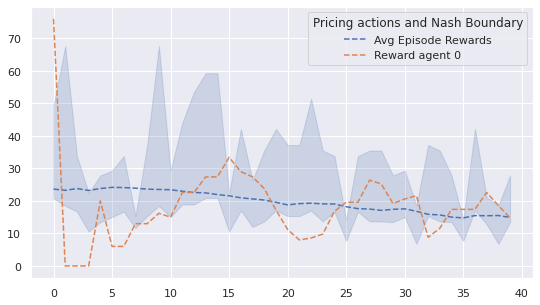

In [266]:
all_rewards = res.episode_rewards
agent_ind = 2
x = res.episode_rewards[:, -1, agent_ind]
smoothed_episode_rewards = moving_average(x)
start = x[0:SM]

# episode rewards all agents
sns.set()
plt.figure(figsize=(9,5))
x = np.arange(len(all_rewards))

plt.plot(x, res.avg_epoch_rewards, '--', label='Avg Episode Rewards')
plt.plot(x, np.concatenate([start, smoothed_episode_rewards]), '--', label='Reward agent 0')
plt.fill_between(x, nash_lower_bound_all_rev_ep, nash_upper_bound_all_rev_ep, color='b', alpha=0.2)
plt.legend(title='Pricing actions and Nash Boundary')

plt.show()


In [267]:
# Max on

# rev_from_ref_price = [est_revenue_from_refprice(v, beta0, beta1, beta2) for v in computed_ref_price_pair]

In [270]:
res.state_tracker.shape

(40, 31)

In [293]:
# maximum revenue from deviations

max_dev_revenue_arr = np.zeros(len(devs))

for e in range(len(devs)):
    v = np.array([res.state_tracker[e, 0], devs[e, 0]])
    max_revenue_from_dev = est_revenue_from_refprice(v, beta0, beta1, beta2)
    for d in range(len(res.state_tracker[e])):
        # v = np.array([res.state_tracker[e, d], res.state_tracker[e, d] - devs[e, d]])
        v = np.array([ref_prices[e], np.mean(res.state_tracker[e]) - devs[e, d]])
        revenue_from_dev = np.clip(est_revenue_from_refprice(v, beta0, beta1, beta2), 0, np.inf)
        if revenue_from_dev > max_revenue_from_dev:
            max_revenue_from_dev = revenue_from_dev
    
    max_dev_revenue_arr[e] = max_revenue_from_dev


In [294]:
max_dev_revenue_arr

array([ 89.98806985,  57.22381962,  68.04847545,  24.55162283,
        59.03797462,  54.15773836,  18.52599475, 100.41331616,
        46.81482702,  38.5299413 ,  66.14779996,  22.73733138,
        68.40029994,  38.65759686,  40.60540629,  59.84055989,
        44.93900875,  40.41500303,  26.33470244,  41.71981039,
        53.56103316,  40.71584073,  70.1253199 ,  60.51519855,
        76.51084779,  38.5299413 ,  30.43552074,  62.11266999,
        14.91729011,  37.63638161,  76.17302527,  53.49158773,
        72.2565669 ,  72.25508026,  72.12400475,  59.540381  ,
        26.97933351,  68.00823823,  76.61310841,  41.85770938])

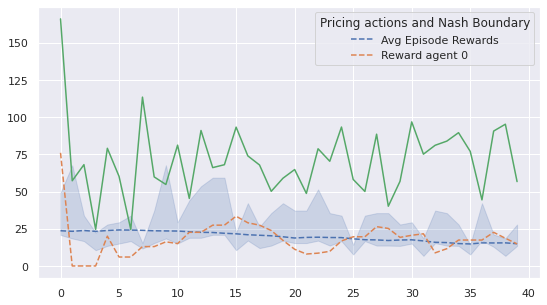

In [295]:
all_rewards = res.episode_rewards
agent_ind = 2
x = res.episode_rewards[:, -1, agent_ind]
smoothed_episode_rewards = moving_average(x)
start = x[0:SM]

# episode rewards all agents
sns.set()
plt.figure(figsize=(9,5))
x = np.arange(len(all_rewards))

plt.plot(x, res.avg_epoch_rewards, '--', label='Avg Episode Rewards')
agent_rewards_plot = np.concatenate([start, smoothed_episode_rewards])
plt.plot(x, agent_rewards_plot, '--', label='Reward agent 0')


plt.fill_between(x, nash_lower_bound_all_rev_ep, nash_upper_bound_all_rev_ep, color='b', alpha=0.2)
plt.legend(title='Pricing actions and Nash Boundary')

plt.plot(agent_rewards_plot + max_dev_revenue_arr)

plt.show()